In [2]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pandas as pd
import datetime
import numpy

In [3]:
colors = ['b','g','r','c','m','y','k']

In [4]:
population = pd.read_csv('~/Downloads/PopulationByCountry.csv')
population['Population'] = population['Population'].str.replace(",","").astype(int)
population.loc[population['Name'] == 'United States','Name'] = 'US'
population.loc[population['Name'] == 'United Kingdom','Name'] = 'UK'
df_all = pd.read_csv('../csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv')
df_all = df_all.drop('Lat', 1)
df_all = df_all.drop('Long', 1)
df = df_all.copy()
df = df.drop('Province/State',1)

In [1241]:
def getDT(dt):
    if isinstance(dt, str):
        return dt
    return dt.strftime("%-m/%-d/%y")
startdatetime = "1/22/20" # datetime.datetime(year=2020, month=1, day=22)
today = df.columns[-1]

In [1246]:
df2 = df.groupby('Country/Region').sum().sort_values(by=getDT(today), ascending=False).T

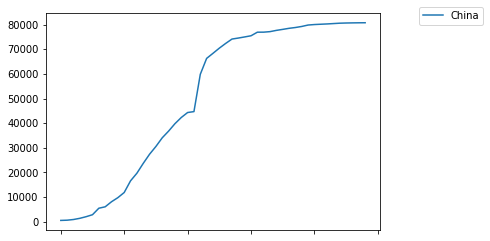

In [1255]:
china = df2['China']
ax = china.plot()
ax.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()

In [1251]:
df.groupby('Country/Region').sum().sort_values(by=getDT(today), ascending=False).T

Country/Region,Mainland China,Italy,Iran (Islamic Republic of),Republic of Korea,France,Spain,US,Germany,Others,Japan,...,Bhutan,Liechtenstein,Burkina Faso,Sri Lanka,Lithuania,Mongolia,Brunei,Channel Islands,Monaco,Paraguay
1/22/20,547,0,0,1,0,0,1,0,0,2,...,0,0,0,0,0,0,0,0,0,0
1/23/20,639,0,0,1,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1/24/20,916,0,0,2,2,0,2,0,0,2,...,0,0,0,0,0,0,0,0,0,0
1/25/20,1399,0,0,2,3,0,2,0,0,2,...,0,0,0,0,0,0,0,0,0,0
1/26/20,2062,0,0,3,3,0,5,0,0,4,...,0,0,0,0,0,0,0,0,0,0
1/27/20,2863,0,0,4,3,0,5,1,0,4,...,0,0,0,1,0,0,0,0,0,0
1/28/20,5494,0,0,4,4,0,5,4,0,7,...,0,0,0,1,0,0,0,0,0,0
1/29/20,6070,0,0,4,5,0,5,4,0,7,...,0,0,0,1,0,0,0,0,0,0
1/30/20,8124,0,0,4,5,0,5,4,0,11,...,0,0,0,1,0,0,0,0,0,0
1/31/20,9783,2,0,11,5,0,7,5,0,15,...,0,0,0,1,0,0,0,0,0,0


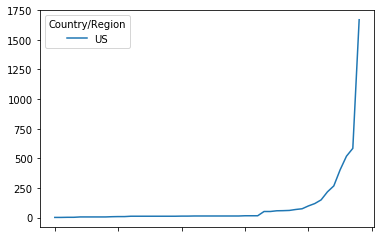

In [1256]:
mapping = {
    'Iran (Islamic Republic of)': 'Iran',
    'Republic of Korea': 'South Korea',
    'Russian Federation': 'Russia',
    'occupied Palestinian territory': 'Palestine',
    'Republic of Moldova': 'Moldova',
    'Macao SAR': 'Macau',
    'Hong Kong SAR': 'Hong Kong',
    'Saint Martin': 'St. Martin',
    'Taipei and environs': 'Taiwan',
    'Holy See': 'Vatican City',
    'Viet Nam': 'Vietnam',
}

#Mainland China

for countryName, oldCountryName in mapping.items():
    if oldCountryName in df2.columns:
        df2[countryName] += df2[oldCountryName]
        df2 = df2.drop(oldCountryName, 1)
    
    if oldCountryName in population['Name'].values:
        population.loc[population['Name']==oldCountryName,'Name'] = countryName

# df2['China'] = df2['Mainland China']
# df2 = df2.drop('Mainland China', 1)
US = df2[['US']]
US.plot()

In [1257]:
def generateAndPlotPrediction(x, y):
    f = lambda t,a,b: a * numpy.exp(b*t)
    popt, _ = curve_fit(f,  x,  y, p0=(4, 0.1))
    y_estimate = f(x, *popt)
    return lambda t: popt[0] * numpy.exp(popt[1] * t)
def generateAndPlotPredictionEstimates(x, y):
    f = lambda t,a,b: a * numpy.exp(b*t)
    popt, _ = curve_fit(f,  x,  y, p0=(4, 0.1))
    y_estimate = f(x, *popt)
    return popt

In [1259]:
def plotCountries(df2, start, end, savefilename='', moredays=0):
    fig = plt.figure()
    ax = plt.subplot(111)
    for i, countryName in enumerate(df2.T[start:end].T.columns):
        if countryName == 'Others':
            continue
        df3 = df2[countryName]
        df4 = df3[df3 != 0]
        x = np.linspace(1, len(df4), len(df4))
        y = df4.values
        f = generateAndPlotPrediction(x, y)
        x2 = np.linspace(1, len(df4) + moredays, len(df4) + moredays)
        ax.plot(x, y, colors[i] + '-', label='data for {}'.format(countryName))
        ax.plot(x2, f(x2), colors[i] + '--', label='fit for {}'.format(countryName))
    if moredays > 0:
        plt.title('number of confirmed infected (COVID-19) -- from day 0 of infection in country -- {} day prediction'.format(moredays))
    else:
        plt.title('number of confirmed infected (COVID-19) -- from day 0 of infection in country')

    # Shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    if savefilename:
        plt.savefig(savefilename)
    plt.show()

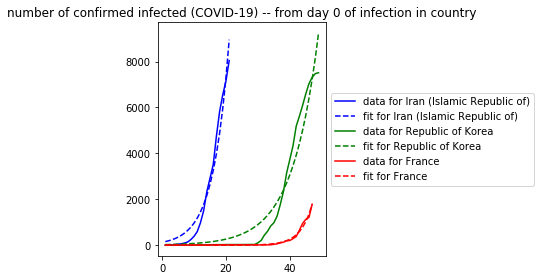

In [1260]:
plotCountries(df2, 1,4, 'SK.Iran.Italy.png',moredays=0)

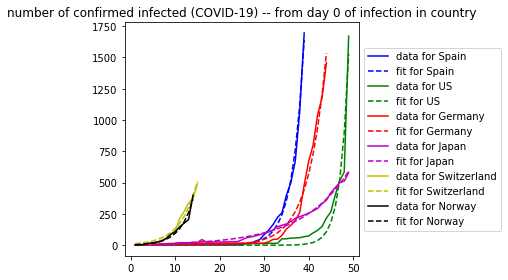

In [1261]:
plotCountries(df2, 4,len(colors) + 4, '4.11.png', moredays=0)

In [1262]:
def plotState(US_all, stateCode, savefig=''):
    stateDf = pd.DataFrame(US_all[US_all['Province/State'].str.contains(stateCode)].T.sum(axis=1).T).reset_index().iloc[1:].set_index('index')
    df4 = stateDf[stateDf != 0].dropna()
    x = np.linspace(1, len(df4), len(df4))
    y = df4.values
    f = generateAndPlotPrediction(x, y.reshape(y.size).astype(int))
    moredays=0
    fig = plt.figure()
    ax = plt.subplot(111)
    x2 = np.linspace(1, len(df4) + moredays, len(df4) + moredays)
    i = 1
    ax.plot(x, y.reshape(y.size).astype(int), colors[i] + '-', label='data for {}'.format(countryName))
    ax.plot(x2, f(x2), colors[i] + '--', label='fit for {}'.format(countryName))
    plt.title("{} Infected Num".format(stateCode))
    plt.tight_layout()
    if savefig != '':
        plt.savefig(savefig)

In [1263]:
US_all = df_all[df_all['Country/Region'] == 'US']
US_all = US_all.drop('Country/Region', 1)

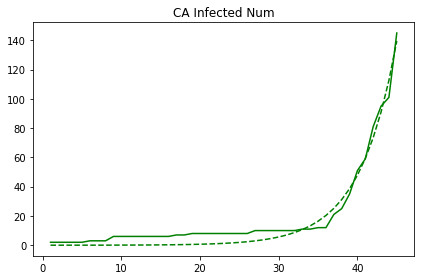

In [1264]:
plotState(US_all, 'CA', 'CA.png')

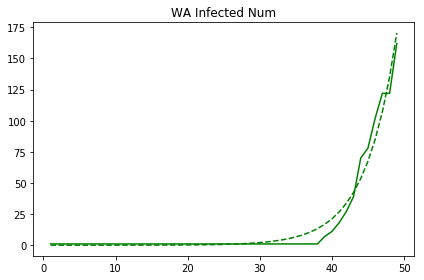

In [1265]:
plotState(US_all, 'WA', 'WA.png')

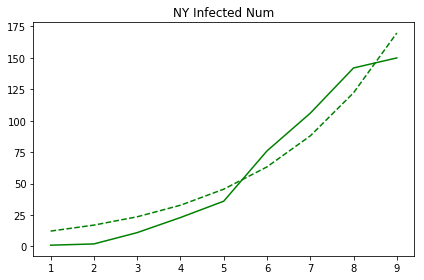

In [1266]:
plotState(US_all, 'NY', 'NY.png')

In [1267]:
dfByPop = pd.merge(df2.iloc[-1:].T.reset_index().rename(columns={'Country/Region':'Name'}), population, on='Name')
dfByPop = dfByPop.rename(columns={getDT(today):'InfectedNum'})
# dfByPop['Population'] = dfByPop['Population'].str.replace(",","").astype(int)
dfByPop['1 in X'] = dfByPop['Population'] / dfByPop['InfectedNum']
dfByPop['% Have It'] = dfByPop['InfectedNum'] / dfByPop['Population']

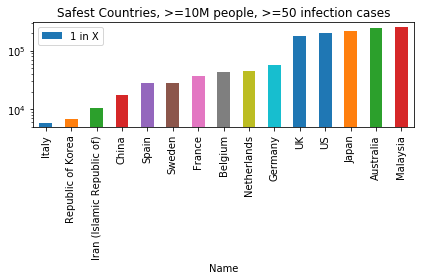

In [1268]:
toPlot = dfByPop[dfByPop['Population'] >= 10e6]
toPlot = toPlot[toPlot['InfectedNum'] >= 100]
toPlot = toPlot.sort_values(by='1 in X')
toPlot[['Name', '1 in X']].plot.bar(x='Name', y='1 in X',logy=True)
plt.title('Safest Countries, >=10M people, >=50 infection cases')
plt.tight_layout()
plt.savefig('safestCountries.1inx.png')

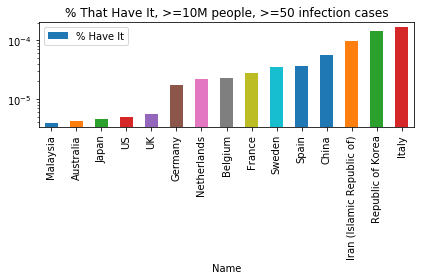

In [1269]:
toPlot = dfByPop[dfByPop['Population'] >= 10e6]
toPlot = toPlot[toPlot['InfectedNum'] >= 100]
toPlot = toPlot.sort_values(by='% Have It')
toPlot[['Name', '% Have It']].plot.bar(x='Name', y='% Have It',logy=True)
plt.title('% That Have It, >=10M people, >=50 infection cases')
plt.tight_layout()
plt.savefig('safestCountries.percenthaveit.png')

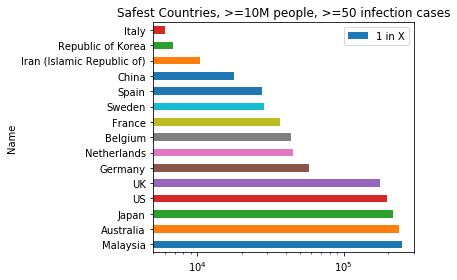

In [1270]:
toPlot = dfByPop[dfByPop['Population'] >= 10e6]
toPlot = toPlot[toPlot['InfectedNum'] >= 100]
toPlot = toPlot.sort_values(by='1 in X')
toPlot[['Name', '1 in X']].iloc[::-1].plot(kind='barh', x='Name', y='1 in X', logx=True)
ax.invert_xaxis()
plt.title('Safest Countries, >=10M people, >=50 infection cases')
plt.tight_layout()
# plt.savefig('safestCountries.2.png')

In [1271]:
notChina = df2.drop('China', 1)
notChina = pd.DataFrame(data=notChina.sum(axis=1).values, columns=['NumInfected'], index=notChina.index)
notChina['delta'] = notChina.diff(axis=0)
notChina = notChina.iloc[1:]
notChina['secondDiv'] = notChina['delta'] / notChina['delta'].shift()
notChina = notChina.iloc[1:]

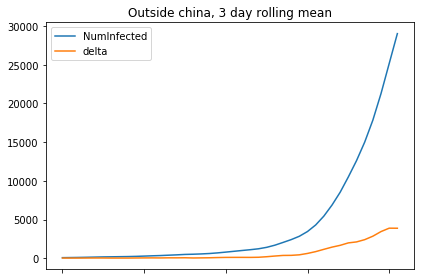

In [1272]:
notChina[['NumInfected','delta']].rolling(3).mean().iloc[4:-1].plot()
plt.title("Outside china, 3 day rolling mean")
plt.tight_layout()
plt.savefig("outsidechina.firstderiv.png")

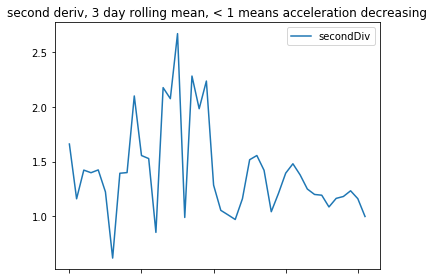

In [1273]:
notChina[['secondDiv']].rolling(3).mean().iloc[4:-1].plot()
plt.title("second deriv, 3 day rolling mean, < 1 means acceleration decreasing")
plt.tight_layout()
plt.savefig("outsidechina.secondderiv.png")

In [1287]:
def predictForwardFromOthers(df, currentVal, inHowManyDays):
    avgT = 0
    avgC = 0
    for countryName in df.iloc[-1:][df.iloc[-1:] > currentVal].dropna(1).columns:
        if 'China' in countryName:
            continue
        previousValue = sum(df[countryName] > currentVal) + 1
        dfIncluding = df[countryName][-previousValue:]
        if (previousValue - 1) < inHowManyDays:
            continue
        previous, nextVal = dfIncluding.iloc[0], dfIncluding.iloc[inHowManyDays]
        avgT += (1 - (currentVal - previous)/currentVal) * (nextVal - currentVal)
        avgC += 1
    return avgT/avgC + currentVal, avgC

In [1279]:
predictForwardFromOthers(df2, 1000, 3) # new york numbe rof cases

(2153.6, 6)

In [1294]:
predictForwardFromOthers(df2, 28, 21)

(1193.146103896104, 11)